In [1]:
import itertools
import os.path
from time import time
from decimal import Decimal
import math

import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

directory = '/data/dwarf-galaxies-stamps2'
info_file = os.path.join(directory, 'stamps2.ecsv')
crop = (224, 224)

Using TensorFlow backend.


In [2]:
def scale_column(column, value):
    vmin, vmax = column_scaling[column]['min'], column_scaling[column]['max']
    return (value - vmin) / (vmax - vmin)


def fexp(number):
    """
    Get the exponent
    """
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1


def roundup(number):
    """
    Round the number up to the nearest factor, but in a nice way
    """

    theexp = fexp(number)

    if theexp < 0:
        return math.ceil(number * 10**abs(theexp)) / (10**abs(theexp))
    else:
        return math.ceil(number * 10**abs(theexp-2)) / (10**abs(theexp-2))
    return
vroundup = np.vectorize(roundup)

def rounddown(number):
    """
    Round down to the nearest factor, but in a nice way
    """

    theexp = fexp(number)

    if theexp < 0:
        return math.floor(number / 10**abs(theexp)) * (10**abs(theexp))
    else:
        return math.floor(number * 10**abs(theexp-2)) / (10**abs(theexp-2))
    return
vrounddown = np.vectorize(rounddown)



In [3]:
# ------------------------------------------------------------------------
#
# Load in the Information File
#
# ------------------------------------------------------------------------
dwarfs_table = Table.read(info_file, format='ascii.ecsv')


columns = ['distance', 'logmass']

column_scaling = {}
for column in columns:
    column_scaling[column] = {
        'min': np.min(vrounddown(dwarfs_table[column])),
        'max': np.max(vroundup(dwarfs_table[column]))
    }

def random_subsets(thelist, subsets):
    used = []

    for subset in subsets:
        all_used = list(itertools.chain(*used))

        possible = list(set(thelist) - set(all_used))

        thesublist = np.random.choice(possible, subset, replace=False)

        used.append(thesublist)

    return used

train = {}
test = {}

indices = range(len(dwarfs_table))

training_test_indices = random_subsets(indices, [8000, 200, 200])
training_indices, validation_indices, test_indices = training_test_indices

## Custom Data Generator

https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

In [4]:
# Step 1 : Define a function to get input (can be subsetting a numpy array, pandas dataframe, reading in from disk etc.) :
def get_input(path):
    
    f = fits.open(os.path.join(directory, path))
    img = f[0].data.astype(np.float64).transpose((1, 2, 0))[16:-16, 16:-16] # move channels to last.
    return(img)


# Step 2 : Define a function to get output :
def get_output(dwarf_table_row, columns):    
    return np.array([scale_column(c, dwarf_table_row[c]) for c in columns])

# Step 3 : Define a function to preprocess input :
def preprocess_input(image):
    
#     --- Rescale Image
#     --- Rotate Image
#     --- Resize Image
#     --- Flip Image
#     --- PCA etc.
    
    return(image)


# Step 4 : Bring everything together to define your generator :
def image_generator(dwarfs_table, row_indices, batch_size = 64):
    """
    Need to pass in dwarfs_table
    indices over which we will do a random choice
    """
    while True:
        # Select files (paths/indices) for the batch
        batch_dwarfs_rows = np.random.choice(a=dwarfs_table[row_indices], size=batch_size, replace=False)

        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for row in batch_dwarfs_rows:
            data = get_input(row['filename'])
            output = get_output(row, columns)

            #input = preprocess_input(image=input)
            batch_input += [ data ]
            batch_output += [ output ]

        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        #batch_x = vgg19_preprocess_input(batch_x)
        batch_x = (batch_x - np.min(batch_x)) / (np.max(batch_x) - np.min(batch_x))

        yield batch_x, batch_y


In [5]:
EPOCHS = 30
BATCH_SIZE = 50

vgg_model = VGG19(weights='imagenet', include_top=False)

# Disassemble layers and remove the prediction layer
ls = [l for l in vgg_model.layers]

# Defining new convolutional layer.
# Important: the number of filters should be the same!
# Note: the receiptive field of two 3x3 convolutions is 5x5.
vgg19_input = layers.Input(shape=(224, 224, 5))
new_conv = layers.Conv2D(filters=3,
                        kernel_size=(1, 1),
                        name='5to3',
                        padding='same')

# Now stack everything back
# Note: If you are going to fine tune the model, do not forget to
#       mark other layers as un-trainable

x = vgg19_input
x = new_conv(x)
for i in range(1, len(ls)):
    ls[i].trainable = False
    x = ls[i](x)

x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(2)(x)

# Final touch
model = keras.Model(input=vgg19_input, output=x)
model.summary()

from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='mean_squared_error')


W0805 19:53:52.965275 140561835828992 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 19:53:52.982637 140561835828992 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 19:53:52.990358 140561835828992 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 19:53:53.019667 140561835828992 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 5)       0         
_________________________________________________________________
5to3 (Conv2D)                (None, 224, 224, 3)       18        
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  147584    
__________

In [6]:
train_generator = image_generator(dwarfs_table, training_indices, batch_size=BATCH_SIZE)
validation_generator = image_generator(dwarfs_table, validation_indices, batch_size=BATCH_SIZE)
test_generator = image_generator(dwarfs_table, test_indices, batch_size=BATCH_SIZE)

steps_per_epoch = len(training_indices)//BATCH_SIZE
validation_steps = len(validation_indices)//BATCH_SIZE

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[])


Epoch 1/30
160/160 [==============================] - 772s 5s/step - loss: 0.0490 - val_loss: 0.0368
Epoch 2/30
160/160 [==============================] - 344s 2s/step - loss: 0.0391 - val_loss: 0.0309
Epoch 3/30
160/160 [==============================] - 162s 1s/step - loss: 0.0380 - val_loss: 0.0335
Epoch 4/30
160/160 [==============================] - 149s 931ms/step - loss: 0.0360 - val_loss: 0.0337
Epoch 5/30
160/160 [==============================] - 149s 931ms/step - loss: 0.0361 - val_loss: 0.0328
Epoch 6/30
160/160 [==============================] - 149s 930ms/step - loss: 0.0353 - val_loss: 0.0382
Epoch 7/30
160/160 [==============================] - 149s 931ms/step - loss: 0.0366 - val_loss: 0.0540
Epoch 8/30
160/160 [==============================] - 149s 931ms/step - loss: 0.0337 - val_loss: 0.0324
Epoch 9/30
160/160 [==============================] - 149s 931ms/step - loss: 0.0349 - val_loss: 0.0369
Epoch 10/30
160/160 [==============================] - 149s 930ms/step - 

KeyboardInterrupt: 

In [7]:
test_features, test_labels = next(image_generator(dwarfs_table, test_indices, batch_size=len(test_indices)))

score = model.evaluate(test_features, test_labels)

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


200/200 [==============================] - 5s 23ms/step


NameError: name 'history' is not defined

<Figure size 504x360 with 0 Axes>

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


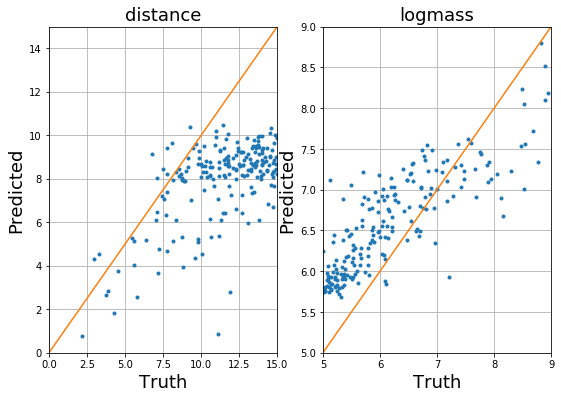

In [8]:
calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]

    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.astype(np.float16).transpose((1, 2, 0))[16:-16, 16:-16] # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])
